In [1]:
!pip install -q opendatasets

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vaniseth
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces


In [4]:
train_dir="/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train"
test_dir="/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test"

In [5]:
print(len(train_dir))
print(len(test_dir))

65
64


In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(train_dir)

There are 2 directories and 0 images in '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'.
There are 0 directories and 50000 images in '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake'.
There are 0 directories and 50000 images in '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real'.


In [7]:
import pandas as pd

df_train = pd.read_csv('/content/140k-real-and-fake-faces/train.csv')
df_test = pd.read_csv('/content/140k-real-and-fake-faces/test.csv')

df_train['full_path'] = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + df_train['path']
df_test['full_path'] = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + df_test['path']

print("Training samples:", len(df_train))
print("Testing samples:", len(df_test))

Training samples: 100000
Testing samples: 20000


In [8]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(df, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Real
        real_img = df[df['label'] == 1].sample(1)
        img_real = Image.open(real_img['full_path'].values[0])
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img_real)
        plt.title('Real')
        plt.axis('off')

        # Fake
        fake_img = df[df['label'] == 0].sample(1)
        img_fake = Image.open(fake_img['full_path'].values[0])
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(img_fake)
        plt.title('Fake')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

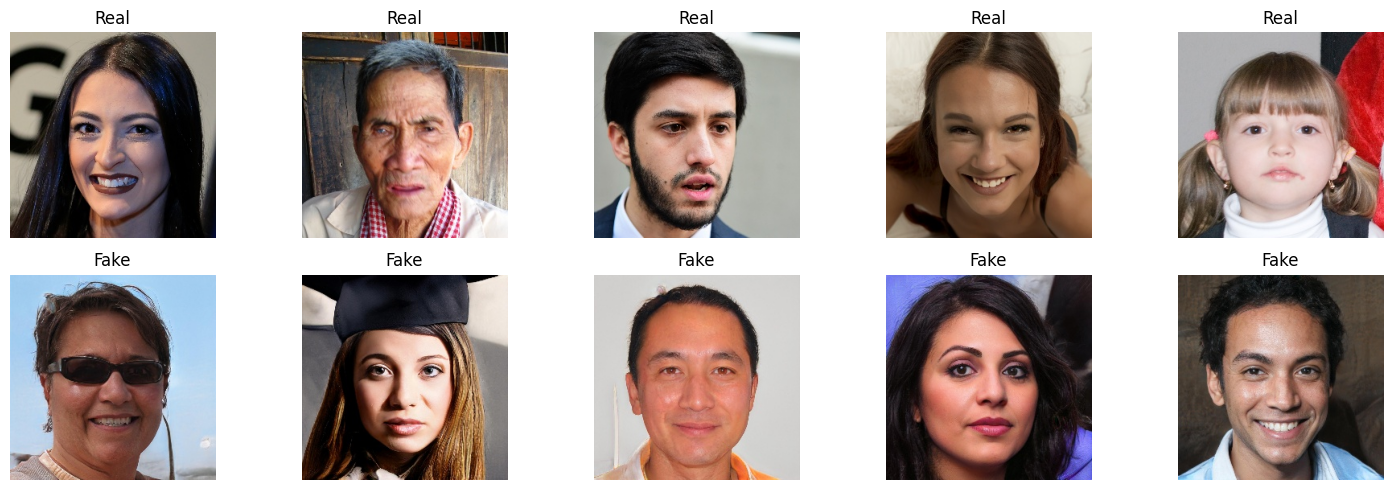

In [9]:
show_sample_images(df_train)

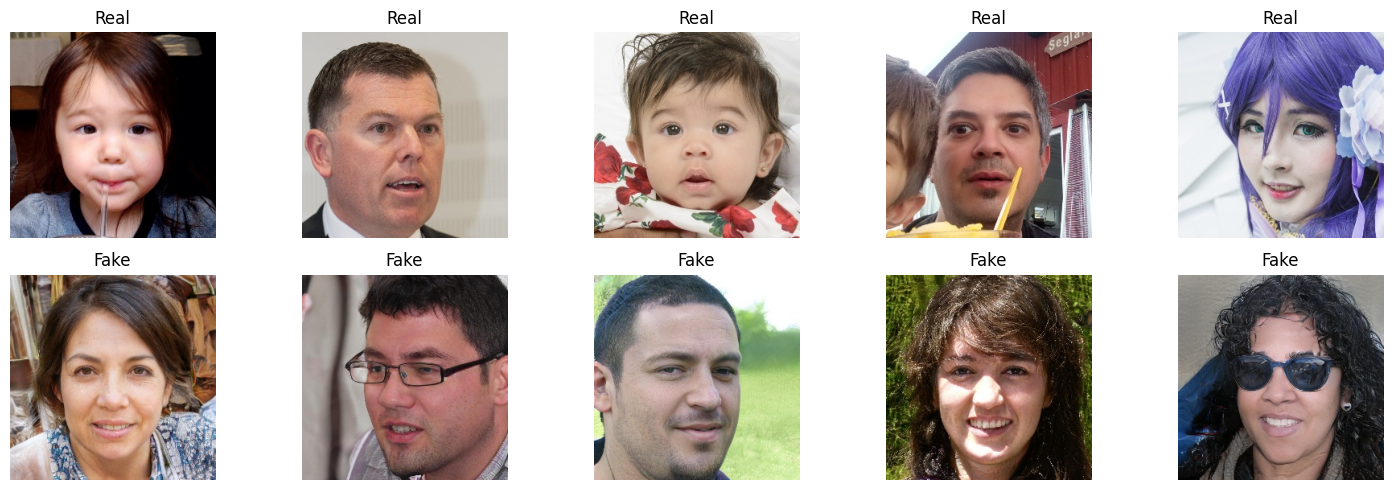

In [10]:
show_sample_images(df_test)

# **Preprocessing**

In [11]:
#original

import numpy as np

def preprocess_image(image_path, target_size=(224, 224), stretch_contrast=True): #original
    img = Image.open(image_path).convert('RGB') #original
    img = img.resize(target_size)  #original lines
    img_array = np.array(img, dtype=np.float32) / 255.0   #original lines

    if stretch_contrast:
        current_max = img_array.max()
        if current_max > 0:
            img_array /= current_max

    return img_array

In [12]:
#original

def process_in_batches(df, batch_size=1000, target_size=(224, 224), stretch_contrast=True):
    num_samples = len(df)
    num_batches = (num_samples + batch_size - 1) // batch_size

    X = np.zeros((num_samples, *target_size, 3), dtype=np.float32)
    y = np.zeros(num_samples, dtype=np.int8)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)

        batch_df = df.iloc[start_idx:end_idx]
        for j, (_, row) in enumerate(batch_df.iterrows()):
            try:
                X[start_idx + j] = preprocess_image(row['full_path'], target_size, stretch_contrast)
                y[start_idx + j] = row['label']
            except Exception as e:
                print(f"Error processing {row['full_path']}: {e}")
                X[start_idx + j] = np.zeros((*target_size, 3))
                y[start_idx + j] = -1

    valid_mask = y != -1
    return X[valid_mask], y[valid_mask]

In [ ]:

# ######### the new function I added

# from PIL import Image, ImageEnhance, ImageFilter
# import cv2
# import numpy as np

# def align_face(img_array):
#     """Detects and centers the face in the image"""
#     try:
#         # Convert to uint8 if needed
#         if img_array.dtype != np.uint8:
#             img_array = (img_array * 255).astype(np.uint8)

#         face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#         gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
#         faces = face_cascade.detectMultiScale(gray, 1.1, 4)

#         if len(faces) > 0:
#             x, y, w, h = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)[0]
#             padding = int(w * 0.2)
#             x1 = max(0, x - padding)
#             y1 = max(0, y - padding)
#             x2 = min(img_array.shape[1], x + w + padding)
#             y2 = min(img_array.shape[0], y + h + padding)
#             return img_array[y1:y2, x1:x2]
#     except Exception as e:
#         print(f"Face alignment failed: {e}")
#     return img_array

# def reduce_noise(pil_img, size=3):
#     """Applies median filter for noise reduction"""
#     return pil_img.filter(ImageFilter.MedianFilter(size=size))

# def sharpen_image(pil_img, factor=1.5):
#     """Applies sharpening to the image"""
#     enhancer = ImageEnhance.Sharpness(pil_img)
#     return enhancer.enhance(factor)

# def preprocess_image(image_path, target_size=(224, 224),
#                      enable_alignment=True,
#                      enable_sharpening=True,
#                      enable_noise_reduction=True,
#                      stretch_contrast=True):
#     try:
#         # Open and convert image
#         img = Image.open(image_path).convert('RGB')

#         # Convert to numpy array (uint8 for OpenCV operations)
#         img_array = np.array(img, dtype=np.uint8)

#         # Face Alignment
#         if enable_alignment:
#             img_array = align_face(img_array)
#             img = Image.fromarray(img_array)

#         # Resize
#         img = img.resize(target_size)

#         # Sharpening
#         if enable_sharpening:
#             img = sharpen_image(img)

#         # Noise reduction
#         if enable_noise_reduction:
#             img = reduce_noise(img)

#         # Convert to float32 and normalize
#         img_array = np.array(img, dtype=np.float32) / 255.0

#         if stretch_contrast:
#             current_max = img_array.max()
#             if current_max > 0:
#                 img_array /= current_max

#         return img_array

#     except Exception as e:
#         print(f"Error processing {image_path}: {e}")
#         # Return blank image if processing fails
#         return np.zeros((*target_size, 3), dtype=np.float32)

# def process_in_batches(df, batch_size=1000, target_size=(224, 224), stretch_contrast=True):
#     num_samples = len(df)
#     num_batches = (num_samples + batch_size - 1) // batch_size

#     X = np.zeros((num_samples, *target_size, 3), dtype=np.float32)
#     y = np.zeros(num_samples, dtype=np.int8)

#     for i in range(num_batches):
#         start_idx = i * batch_size
#         end_idx = min((i + 1) * batch_size, num_samples)

#         batch_df = df.iloc[start_idx:end_idx]
#         for j, (_, row) in enumerate(batch_df.iterrows()):
#             try:
#                 X[start_idx + j] = preprocess_image(
#                     row['full_path'],
#                     target_size=target_size,
#                     stretch_contrast=stretch_contrast
#                 )
#                 y[start_idx + j] = row['label']
#             except Exception as e:
#                 print(f"Error processing {row['full_path']}: {e}")
#                 X[start_idx + j] = np.zeros((*target_size, 3), dtype=np.float32)
#                 y[start_idx + j] = -1

#     valid_mask = y != -1
#     return X[valid_mask], y[valid_mask]

# # Sample usage
# sample_size = 2000
# df_sample = df_train.sample(sample_size, random_state=42)
# X_sample, y_sample = process_in_batches(df_sample)

In [13]:
#original

sample_size = 2000
df_sample = df_train.sample(sample_size, random_state=42)

X_sample, y_sample = process_in_batches(df_sample)

In [14]:
print("\nSample dataset processed:")
print("Images shape:", X_sample.shape)
print("Labels shape:", y_sample.shape)
print("Pixel value range:", X_sample.min(), "-", X_sample.max())


Sample dataset processed:
Images shape: (2000, 224, 224, 3)
Labels shape: (2000,)
Pixel value range: 0.0 - 1.0


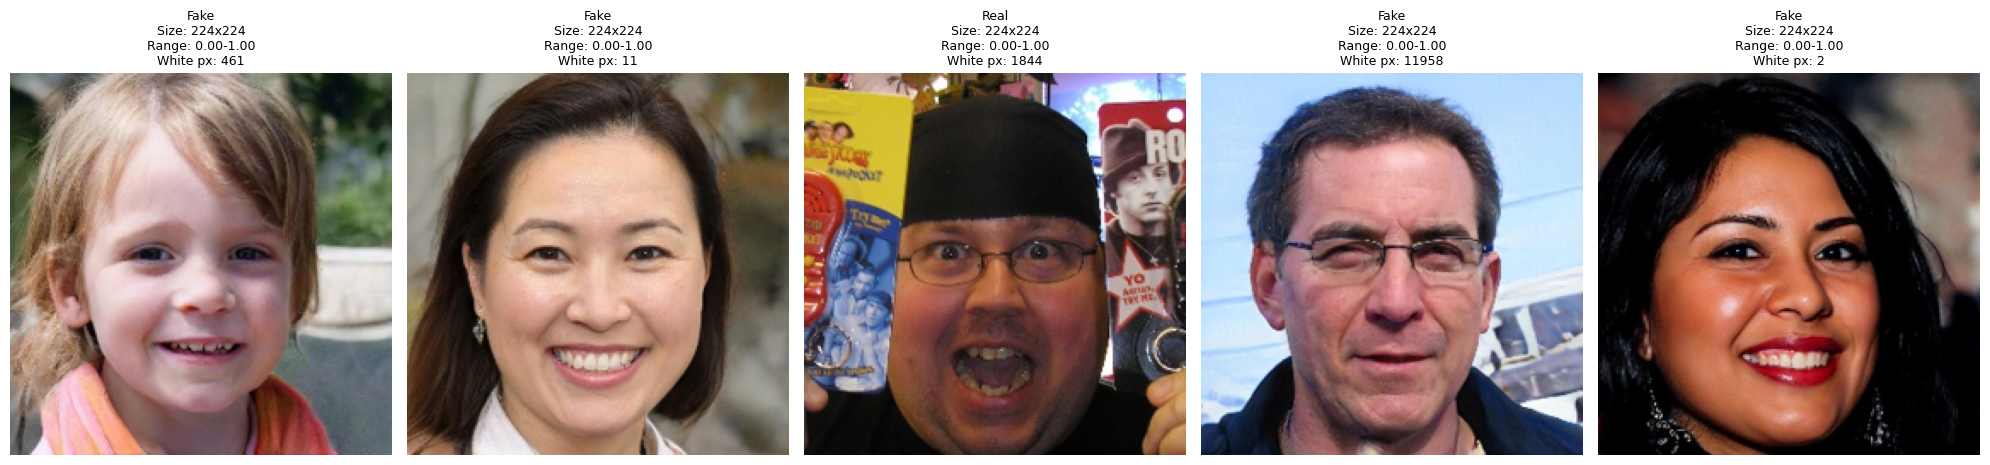


Verification Table (All values should be 0 ≤ x ≤ 1)
-----------------------------------------------------------------
Sample Min      Max      Mean     White Pixels Size      
-----------------------------------------------------------------
1      0.0000   1.0000   0.5041   461          224x224   
2      0.0000   1.0000   0.4462   11           224x224   
3      0.0000   1.0000   0.3277   1844         224x224   
4      0.0000   1.0000   0.5770   11958        224x224   
5      0.0000   1.0000   0.2417   2            224x224   


In [15]:
def show_processed_images_with_stats(X, y, num_samples=5):
    plt.figure(figsize=(20, 5))
    stats = []

    for i in range(min(num_samples, len(X))):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X[i])

        img_stats = {
            'min': X[i].min(),
            'max': X[i].max(),
            'mean': X[i].mean(),
            'white_px': np.sum(X[i] >= 0.99),
            'size': f"{X[i].shape[0]}x{X[i].shape[1]}"
        }
        stats.append(img_stats)

        title = [
            f"{'Real' if y[i] == 1 else 'Fake'}",
            f"Size: {img_stats['size']}",
            f"Range: {img_stats['min']:.2f}-{img_stats['max']:.2f}",
            f"White px: {img_stats['white_px']}"
        ]
        plt.title("\n".join(title), fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\nVerification Table (All values should be 0 ≤ x ≤ 1)")
    print("-"*65)
    print(f"{'Sample':<6} {'Min':<8} {'Max':<8} {'Mean':<8} {'White Pixels':<12} {'Size':<10}")
    print("-"*65)
    for i, s in enumerate(stats):
        print(f"{i+1:<6} {s['min']:<8.4f} {s['max']:<8.4f} {s['mean']:<8.4f} {s['white_px']:<12} {s['size']:<10}")

show_processed_images_with_stats(X_sample, y_sample)

In [16]:
# 9. Full Dataset Processing (False right now)
full_dataset = False

if full_dataset:
    print("\nProcessing full training dataset...")
    X_train, y_train = process_in_batches(df_train)

    print("\nProcessing test dataset...")
    X_test, y_test = process_in_batches(df_test)

    print("\nFull dataset processed:")
    print("Training shape:", X_train.shape)
    print("Test shape:", X_test.shape)
else:
    print("\nSkipping full dataset processing to avoid memory issues")
    print("To process full dataset, set full_dataset=True")


Skipping full dataset processing to avoid memory issues
To process full dataset, set full_dataset=True


# **MODEL BUILDING - CNN**

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)

Train size: (1600, 224, 224, 3)
Validation size: (400, 224, 224, 3)


In [19]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # for binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.5214 - loss: 0.8402 - val_accuracy: 0.5350 - val_loss: 0.6895
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5381 - loss: 0.6894 - val_accuracy: 0.6075 - val_loss: 0.6737
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6187 - loss: 0.6608 - val_accuracy: 0.6450 - val_loss: 0.6481
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.6403 - loss: 0.6358 - val_accuracy: 0.6675 - val_loss: 0.6618
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7079 - loss: 0.5734 - val_accuracy: 0.6675 - val_loss: 0.6305
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7508 - loss: 0.5378 - val_accuracy: 0.6575 - val_loss: 0.7210
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7870 - loss: 0.4489 - val_accuracy: 0.6100 - val_loss: 0.8038
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7995 - loss: 0.4102 - val_accuracy: 0.6725 -

# **Making it more interactive**

In [22]:
def predict_single_image(model, image_path, true_label=None, target_size=(224, 224)):
    """
    Predict if a given image is real or fake, and compare with true label if provided.

    Args:
        model: Trained Keras model
        image_path: Path to the image
        true_label: Actual label (0=fake, 1=real), optional
        target_size: Resize target (default 224x224)

    Returns:
        prediction_label: "Real" or "Fake"
        confidence: prediction probability
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred_prob = model.predict(img_array, verbose=0)[0][0]
    prediction_label = "Real" if pred_prob >= 0.5 else "Fake"
    confidence = pred_prob if pred_prob >= 0.5 else 1 - pred_prob

    plt.imshow(img)
    title_text = f"Predicted: {prediction_label} ({confidence*100:.2f}%)"
    if true_label is not None:
        true_text = "Real" if true_label == 1 else "Fake"
        title_text += f"\nTrue Label: {true_text}"
    plt.title(title_text)
    plt.axis('off')
    plt.show()

    return prediction_label, confidence

In [23]:
def batch_predict_and_visualize(model, df, num_samples=10, target_size=(224, 224)):
    """
    Predict multiple random images and visualize results with true labels.

    Args:
        model: Trained model
        df: DataFrame containing 'full_path' and 'label'
        num_samples: How many images to predict
        target_size: Resize target
    """
    # getting random rows
    sample_df = df.sample(num_samples, random_state=42)

    plt.figure(figsize=(20, 8))

    for idx, (_, row) in enumerate(sample_df.iterrows()):

        img = Image.open(row['full_path']).convert('RGB')
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized, dtype=np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred_prob = model.predict(img_array, verbose=0)[0][0]
        pred_label = "Real" if pred_prob >= 0.5 else "Fake"
        confidence = pred_prob if pred_prob >= 0.5 else 1 - pred_prob

        true_label = "Real" if row['label'] == 1 else "Fake"

        plt.subplot(2, (num_samples+1)//2, idx+1)
        plt.imshow(img)
        title_color = 'green' if pred_label == true_label else 'red'
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}\n({confidence*100:.1f}%)", color=title_color, fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

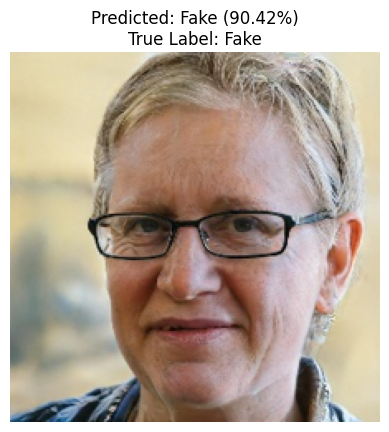

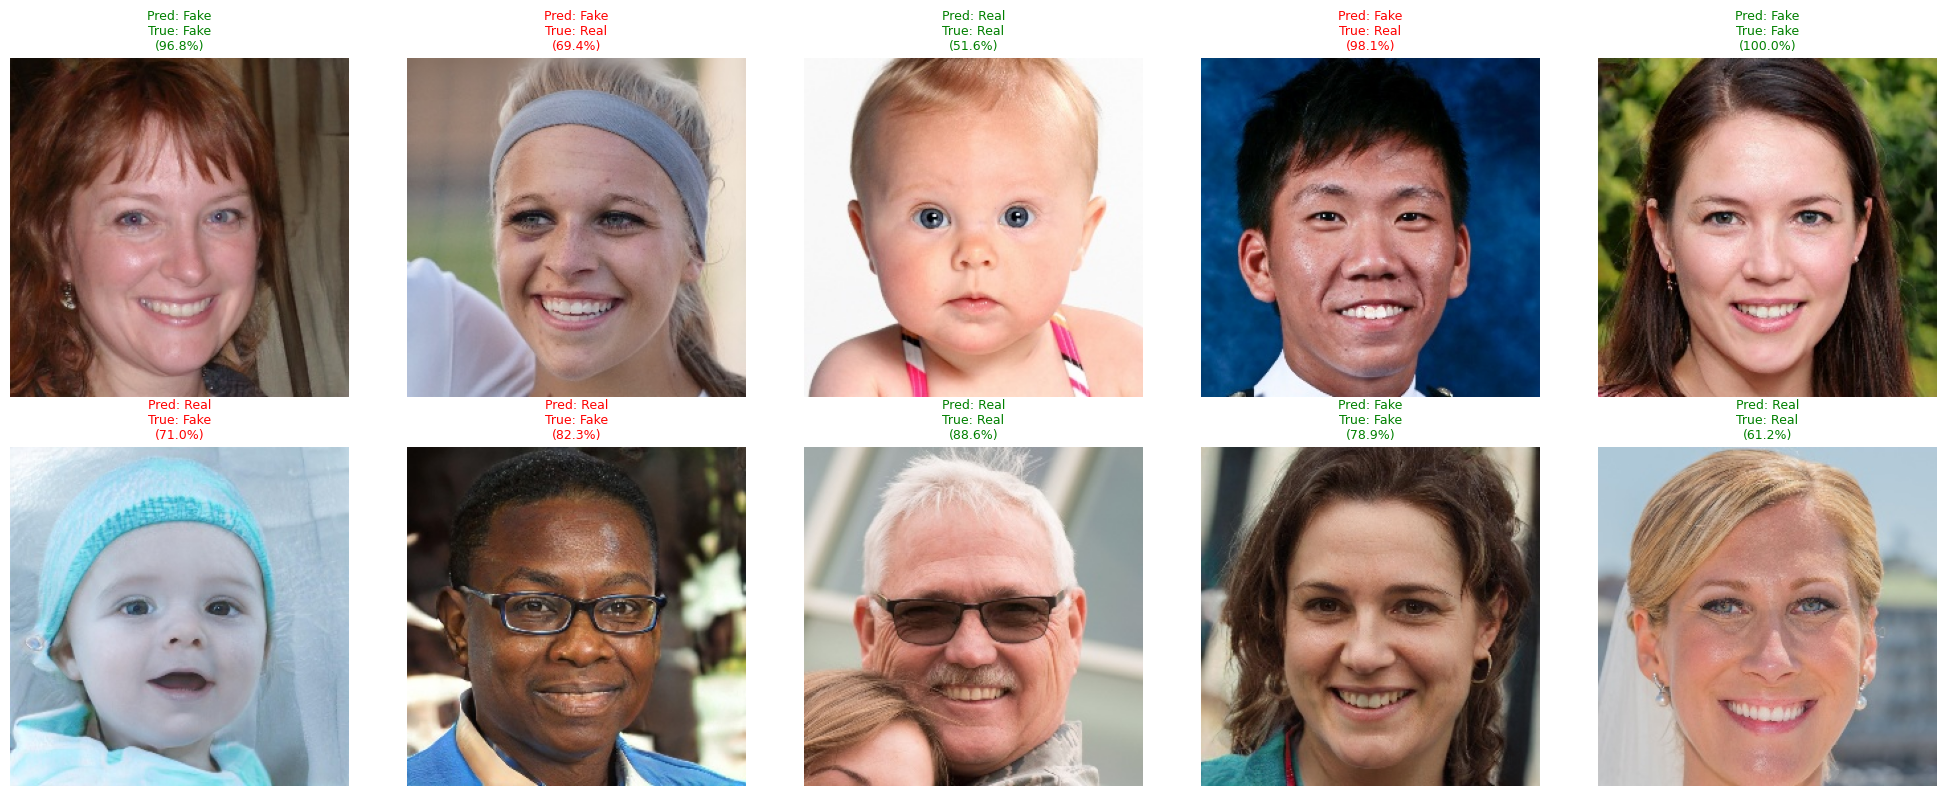

In [24]:
# Predict a single random image
random_row = df_test.sample(1).iloc[0]
predict_single_image(model, random_row['full_path'], true_label=random_row['label'])

# Predicting a batch of 10 random images
batch_predict_and_visualize(model, df_test, num_samples=10)


# **User is uploading the image**

In [ ]:
from google.colab import files
from PIL import Image
import io

def upload_and_predict(model, target_size=(224, 224)):
    """
    Upload an image from local machine and predict Real/Fake.
    Args:
        model: Trained Keras model
        target_size: Tuple (height, width) for resizing the uploaded image
    """
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing file: {filename}")
        image_data = uploaded[filename]
        img = Image.open(io.BytesIO(image_data)).convert('RGB')
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized, dtype=np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred_prob = model.predict(img_array, verbose=0)[0][0]
        prediction = "Real" if pred_prob >= 0.5 else "Fake"
        confidence = pred_prob if pred_prob >= 0.5 else 1 - pred_prob

        plt.imshow(img)
        plt.title(f"Prediction: {prediction} ({confidence*100:.2f}%)")
        plt.axis('off')
        plt.show()

        print(f"Prediction: {prediction}")
        print(f"Confidence: {confidence*100:.2f}%")

In [ ]:
upload_and_predict(model)

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# **Simple CNN**

In [26]:
def simple_cnn(input_shape=(224,224,3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # for binary classification
    ])
    return model


# **Using DeepCNN**

In [27]:
def build_deep_cnn(input_shape=(224,224,3)):
    model = Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# **Using Transfer Learning -> ResNet50 and MobileNetV2**

In [28]:
def build_transfer_model(base_model_name='ResNet50', input_shape=(224,224,3)):
    if base_model_name.lower() == 'resnet50':
        base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name.lower() == 'mobilenetv2':
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported model name. Choose 'ResNet50' or 'MobileNetV2'.")

    base_model.trainable = False  # Freeze base layer
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [29]:
def train_models(model, model_name, epochs=10, batch_size=32):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(f"\nTraining {model_name}...\n")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )

# **Prinitng model architectures**

In [30]:
models_to_train = {
    "Simple CNN": simple_cnn(),
    "Deep CNN": build_deep_cnn(),
    "ResNet50": build_transfer_model('resnet50'),
    "MobileNetV2": build_transfer_model('mobilenetv2')
}

for model_name, model in models_to_train.items():
    print(f"\n===== {model_name} Architecture =====\n")
    model.summary()
    print("\n" + "="*60 + "\n")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

===== Simple CNN Architecture =====



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)




===== Deep CNN Architecture =====



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,161,889 (73.10 MB)

 Trainable params: 19,161,889 (73.10 MB)

 Non-trainable params: 0 (0.00 B)




===== ResNet50 Architecture =====



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)




===== MobileNetV2 Architecture =====



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
# Train other 3 models
for model_name, model in models_to_train.items():
    if model_name != "Simple CNN": # skip
        train_models(model, model_name, epochs=10, batch_size=32)


Training Deep CNN...

Epoch 1/10
50/50 - 32s - 642ms/step - accuracy: 0.5081 - loss: 0.7359 - val_accuracy: 0.5125 - val_loss: 0.6926
Epoch 2/10
50/50 - 18s - 359ms/step - accuracy: 0.5156 - loss: 0.6933 - val_accuracy: 0.5725 - val_loss: 0.6896
Epoch 3/10
50/50 - 10s - 209ms/step - accuracy: 0.5331 - loss: 0.6918 - val_accuracy: 0.5850 - val_loss: 0.6884
Epoch 4/10
50/50 - 10s - 205ms/step - accuracy: 0.5581 - loss: 0.6889 - val_accuracy: 0.5700 - val_loss: 0.6798
Epoch 5/10
50/50 - 6s - 125ms/step - accuracy: 0.5925 - loss: 0.6798 - val_accuracy: 0.5125 - val_loss: 0.7052
Epoch 6/10
50/50 - 10s - 209ms/step - accuracy: 0.5725 - loss: 0.6818 - val_accuracy: 0.5725 - val_loss: 0.6798
Epoch 7/10
50/50 - 10s - 204ms/step - accuracy: 0.6094 - loss: 0.6598 - val_accuracy: 0.6500 - val_loss: 0.6454
Epoch 8/10
50/50 - 6s - 127ms/step - accuracy: 0.6444 - loss: 0.6348 - val_accuracy: 0.6125 - val_loss: 0.6615
Epoch 9/10
50/50 - 10s - 205ms/step - accuracy: 0.6712 - loss: 0.6124 - val_accurac

# **Understanding params for each model**

In [32]:
for model_name, model in models_to_train.items():
    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = total_params - trainable_params

    print(f"\nModel: {model_name}")
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-Trainable Parameters: {non_trainable_params}\n")



Model: Simple CNN
Total Parameters: 11169089
Trainable Parameters: 11169089
Non-Trainable Parameters: 0


Model: Deep CNN
Total Parameters: 19161889
Trainable Parameters: 19161889
Non-Trainable Parameters: 0


Model: ResNet50
Total Parameters: 23850113
Trainable Parameters: 262401
Non-Trainable Parameters: 23587712


Model: MobileNetV2
Total Parameters: 2422081
Trainable Parameters: 164097
Non-Trainable Parameters: 2257984



Performance Evaluation & Visualization

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step

Validation Accuracy: 0.7550
Validation Loss: 0.4966
Validation AUC: 0.8701


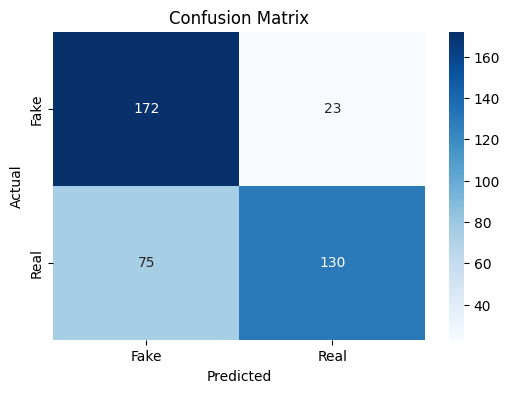


Classification Report:
              precision    recall  f1-score   support

        Fake       0.70      0.88      0.78       195
        Real       0.85      0.63      0.73       205

    accuracy                           0.76       400
   macro avg       0.77      0.76      0.75       400
weighted avg       0.77      0.76      0.75       400



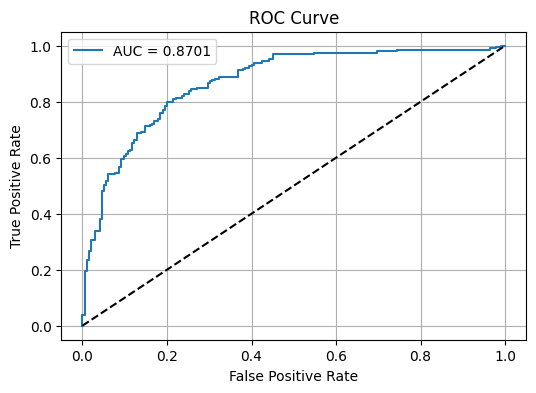

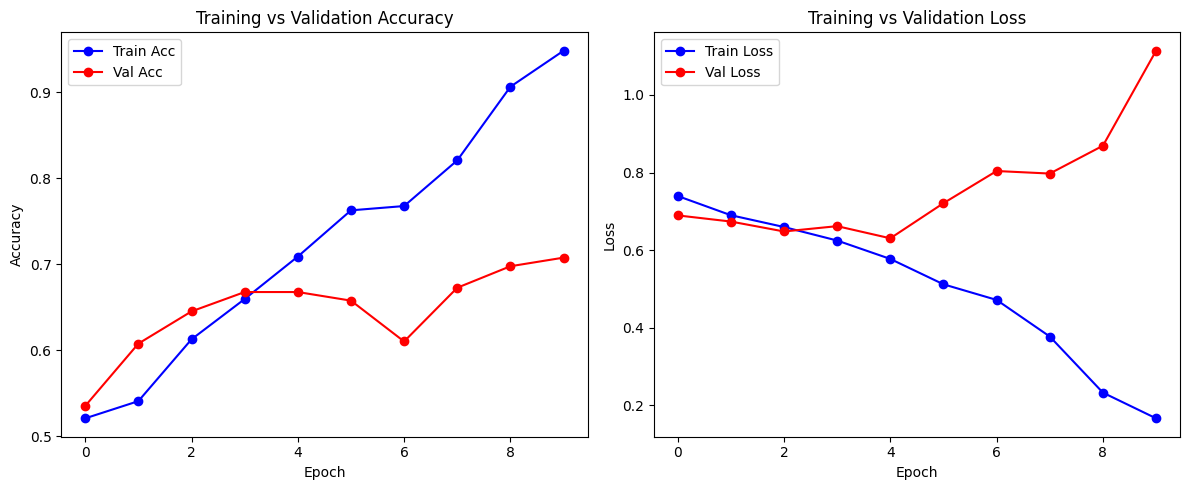

In [33]:
# === PERFORMANCE EVALUATION & VISUALIZATION BLOCKS ===

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions (already computed earlier)
y_pred = model.predict(X_val).flatten()
y_pred_binary = (y_pred >= 0.5).astype(int)

# Basic Metrics
val_acc = accuracy_score(y_val, y_pred_binary)
val_loss = log_loss(y_val, y_pred)
val_auc = roc_auc_score(y_val, y_pred)

print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# 1. Confusion Matrix
conf_mat = confusion_matrix(y_val, y_pred_binary)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_binary, target_names=["Fake", "Real"]))

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 4. Training History Plot
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo-', label='Train Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Val Acc')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Val Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [34]:
# === Predict & Evaluate Deep CNN, ResNet50, and MobileNetV2 ===
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

evaluation_results = {}

for model_name, trained_model in models_to_train.items():
    if model_name == "Simple CNN":
        continue  # Skip since already evaluated

    y_pred = trained_model.predict(X_val).flatten()
    y_pred_binary = (y_pred >= 0.5).astype(int)

    acc = accuracy_score(y_val, y_pred_binary)
    loss = log_loss(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_pred)

    evaluation_results[model_name] = {
        "accuracy": acc,
        "loss": loss,
        "auc": auc_val,
        "pred": y_pred,
        "pred_binary": y_pred_binary
    }

    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"AUC: {auc_val:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

--- Deep CNN ---
Accuracy: 0.6375
Loss: 0.6403
AUC: 0.6996
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step

--- ResNet50 ---
Accuracy: 0.5125
Loss: 0.6929
AUC: 0.6210
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

--- MobileNetV2 ---
Accuracy: 0.7550
Loss: 0.4966
AUC: 0.8701



=== Deep CNN ===
              precision    recall  f1-score   support

        Fake       0.58      0.73      0.65       195
        Real       0.66      0.50      0.57       205

    accuracy                           0.61       400
   macro avg       0.62      0.62      0.61       400
weighted avg       0.62      0.61      0.61       400



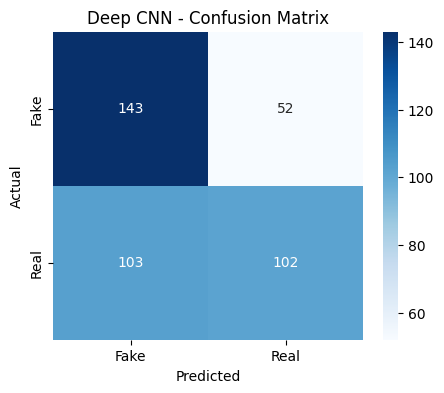

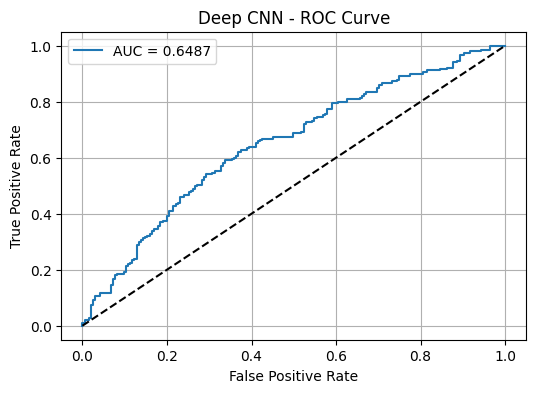


=== ResNet50 ===
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00       195
        Real       0.51      1.00      0.68       205

    accuracy                           0.51       400
   macro avg       0.26      0.50      0.34       400
weighted avg       0.26      0.51      0.35       400



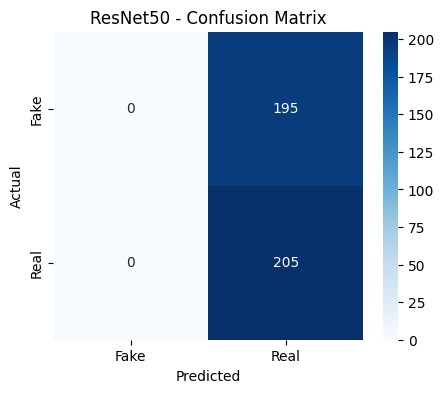

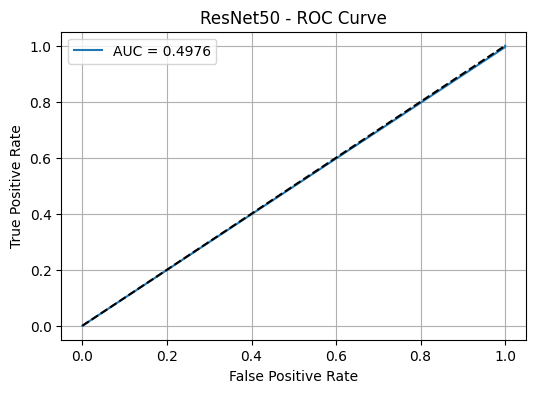


=== MobileNetV2 ===
              precision    recall  f1-score   support

        Fake       0.73      0.78      0.76       195
        Real       0.78      0.73      0.75       205

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.75       400
weighted avg       0.76      0.76      0.75       400



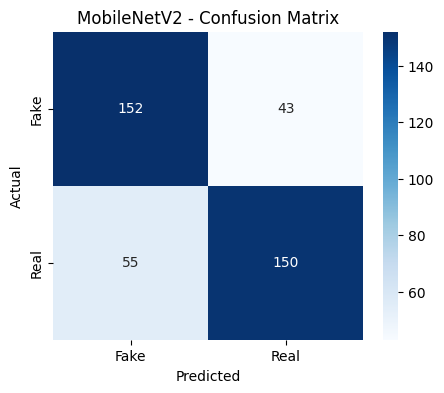

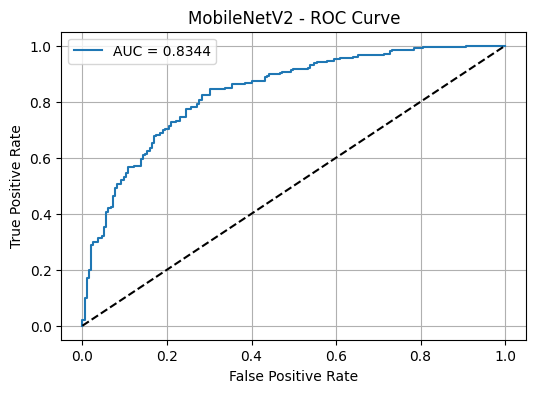

In [ ]:
# === Confusion Matrix, ROC Curve & Classification Report ===
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

for model_name, results in evaluation_results.items():
    y_pred = results["pred"]
    y_pred_binary = results["pred_binary"]

    print(f"\n=== {model_name} ===")
    print(classification_report(y_val, y_pred_binary, target_names=["Fake", "Real"], zero_division=0))

    # Confusion Matrix
    conf_mat = confusion_matrix(y_val, y_pred_binary)
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')  # <- FIXED: no extra color arg
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
print("Evaluation results:", evaluation_results)

Evaluation results: {'Deep CNN': {'accuracy': 0.6125, 'loss': 0.6832118082611739, 'auc': np.float64(0.6487054409005629), 'pred': array([0.2620986 , 0.5447727 , 0.15504548, 0.5809792 , 0.6222694 ,
       0.33244932, 0.43599662, 0.22614753, 0.4401479 , 0.5528133 ,
       0.53378546, 0.26946792, 0.6021018 , 0.16631524, 0.5558264 ,
       0.37756222, 0.57751584, 0.14475621, 0.6089816 , 0.55621713,
       0.251361  , 0.16898462, 0.21922415, 0.31390178, 0.419782  ,
       0.81940436, 0.59036773, 0.9646412 , 0.2670951 , 0.4331048 ,
       0.41801542, 0.47630125, 0.37124404, 0.4757326 , 0.37109143,
       0.36779436, 0.19209069, 0.4521876 , 0.59483147, 0.69158125,
       0.20062143, 0.35366392, 0.4146546 , 0.43505782, 0.5540375 ,
       0.03416002, 0.13611877, 0.36791754, 0.4227006 , 0.4890919 ,
       0.15891005, 0.39160383, 0.11284425, 0.19202994, 0.57733417,
       0.31519485, 0.2011327 , 0.49315354, 0.1564614 , 0.7222133 ,
       0.32323563, 0.60975826, 0.17116967, 0.6133485 , 0.13587013,


In [ ]:
print("Model Accuracies for Line Graph:")
for name, acc in model_accuracies.items():
    print(f"{name}: {acc}")

Model Accuracies for Line Graph:


NameError: name 'model_accuracies' is not defined

In [ ]:
# Simple CNN results
evaluation_results["Simple CNN"] = {
    "accuracy": val_acc,  # computed earlier
    "loss": val_loss,
    "auc": val_auc,
    "pred": y_pred,
    "pred_binary": y_pred_binary
}


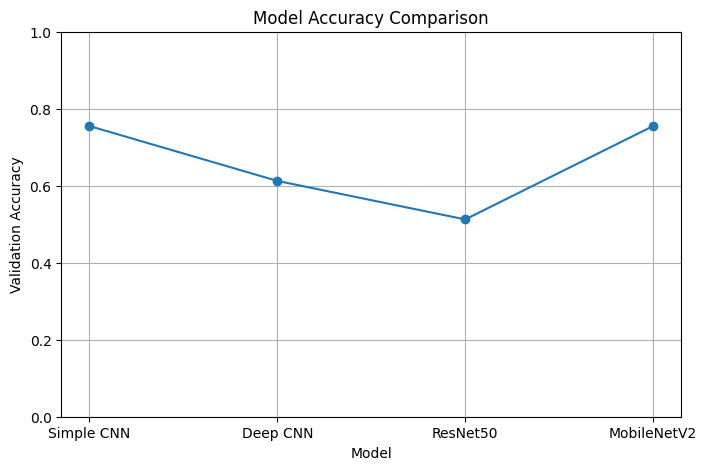

In [ ]:
# Line graph
ordered_model_names = ["Simple CNN", "Deep CNN", "ResNet50", "MobileNetV2"]
model_accuracies = {name: evaluation_results[name]["accuracy"] for name in ordered_model_names}

plt.figure(figsize=(8,5))
plt.plot(list(model_accuracies.keys()), list(model_accuracies.values()), marker='o', linestyle='-')
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy")
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()
